In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import image
import pandas as pd
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [8]:
case = "MESOCOM"
path = "/glade/scratch/jinmuluo/archive/MESOCOM//lnd/hist/" 
h = 'h0'
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 1)
delta = end_date - start_date
roiVars = ['SMINN', 'SMIN_NH4', 'SMIN_NO3', 'SMINN_TO_PLANT_FUN', 'SMINN_TO_PLANT', 'SMIN_NO3_LEACHED', 'SMIN_NO3_RUNOFF',
           'SMINN_TO_PLANT_FUN_NH4', 'SMINN_TO_PLANT_FUN_NO3', 'NFIX', 'FFIX_TO_SMINN']


delta_months = (end_date.year - start_date.year)*12 + end_date.month - start_date.month + 1
fanCLM = []
for i in range(delta_months):
    month = start_date + relativedelta(months=i)
    month = month.strftime('%Y-%m')
    fanCLM.append(path + case + ".clm2." + h + "." + month +".nc")

In [9]:
def preprocess(ds, fields = roiVars):
    return(ds[fields])

def fix_time(ds):  
    date0 = ds['time'][0].values
    date1 = ds['time'][-1].values
    # ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ds['time'] = pd.date_range(str(date0),str(date1),freq='MS') 
    
    return ds

dsCLM = fix_time(xr.open_mfdataset(fanCLM, decode_times=True, preprocess=preprocess))
dsCLM

<xarray.Dataset>
Dimensions:                 (time: 12, lndgrid: 1, levdcmp: 25)
Coordinates:
  * levdcmp                 (levdcmp) float32 0.01 0.04 0.09 ... 28.87 42.0
  * time                    (time) datetime64[ns] 2022-02-01 ... 2023-01-01
Dimensions without coordinates: lndgrid
Data variables:
    SMINN                   (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMIN_NH4                (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMIN_NO3                (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMINN_TO_PLANT_FUN      (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMINN_TO_PLANT          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMIN_NO3_LEACHED        (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMIN_NO3_RUNOFF         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMINN_TO_PLANT_FUN_NH4  (time, levdcmp, lndgrid) float32 dask.array<chunksize=(1, 25, 1), meta=np.ndarray>
    SMINN_TO_PLANT_FUN_NO3  (time, levdcmp, lndgrid) float32 dask.array<chunksize=(1, 25, 1), meta=np.ndarray>
    NFIX                    (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FFIX_TO_SMINN           (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/11/23 14:18:09
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./MESOCOM.clm2.h1.2022-01-01-00000.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

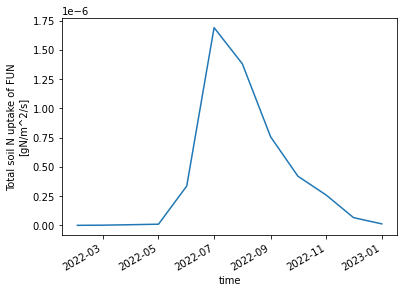

In [10]:
dsCLM.SMINN_TO_PLANT_FUN.plot()

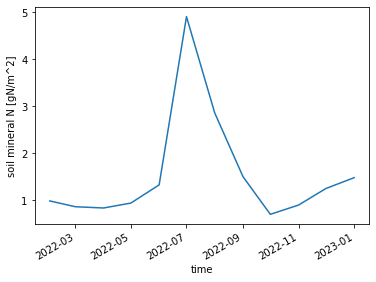

In [11]:
dsCLM.SMINN.plot()

In [ ]:
def sp_plot(ds, field, coords, show=False):
    sp = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
    if show:
        sp[field].plot(x='time')
        plt.show()
    return sp

In [ ]:
def tot_plot(ds, field, show=False, zerol=False, savefig=False):
    # calculate global total emission
    if len(field) > 1:
        for i, var in enumerate(field):
            if i == 0:
                total = ds[var] * ds['area'] * ds['landfrac']
            else:
                total = total + ds[var] * ds['area'] * ds['landfrac']
        total = total.sum(dim=['lat', 'lon'])*0.36*24*30
        total.attrs['units'] = 'GgN/month'
    else:
        var = field[0]
        total = ds[var] * ds['area'] * ds['landfrac']
        total = total.sum(dim=['lat', 'lon'])*0.36*24*30
        total.attrs['units'] = 'GgN/month'
    
    if show:
        total.plot(x='time')
        if zerol:
            x = total.time
            y = np.zeros(len(x))
            plt.plot(x, y, linestyle='dashed', c='black', alpha=0.5)
        plt.title(field)
        plt.ylabel(total.attrs['units'])
        plt.show()
            
    if savefig:
        plt.savefig(field, dpi=150)
    
    return total

In [26]:
def regional_plot(ds, field, coords, show=False):
    x = slice(coords['lower_lat'], coords['upper_lat'])
    y = slice(coords['west_lon'], coords['east_lon'])
    # gN/m2/s to TonN/s
    rp = (ds[field].sel(lat=x, lon=y) * ds['area'].sel(lat=x, lon=y))* ds['landfrac'].sel(lat=x, lon=y).sum(dim=['lat', 'lon'])
    rp.attrs['units'] = 'Tons N/sec'
    if show:
        rp.plot(x='time')
        plt.title(field)
        plt.ylabel(rp.attrs['units'])
        plt.show()
    return rp

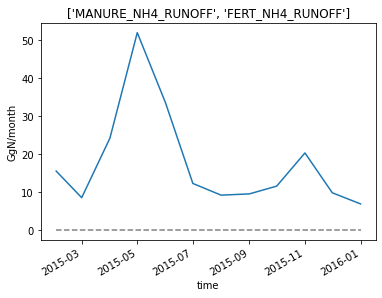

<xarray.DataArray (time: 12)>
dask.array<mul, shape=(12,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-02-01 2015-03-01 ... 2016-01-01
Attributes:
    units:    GgN/month

In [33]:
tot_plot(ds=dsCLM, field=['MANURE_NH4_RUNOFF', 'FERT_NH4_RUNOFF'], show=True, zerol =True, savefig=False)

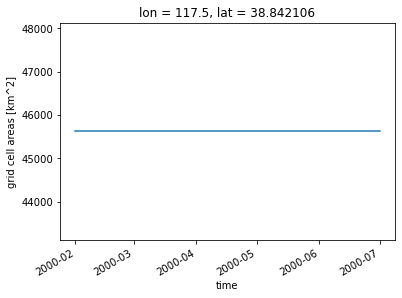

In [9]:
coordinates = [39.24, 116.25]
sp = sp_plot(ds=dsCLM, field=choose_field(h)[4], coords=coordinates, show=True)

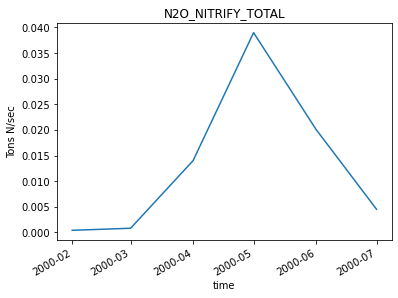

<xarray.DataArray (time: 6)>
dask.array<sum-aggregate, shape=(6,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-03-01 ... 2000-07-01
Attributes:
    units:    Tons N/sec

In [10]:
coordinates = {'upper_lat':45.50, 'lower_lat':25.35, 'west_lon': 100.00, 'east_lon':130.00}
regional_plot(ds=dsCLM, field=choose_field(h)[1], coords=coordinates, show=True)